In [99]:
import keras_tuner as kt
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import tensorflow as tf
from tensorflow import keras

In [140]:
#import the dataset
(training_images, training_labels),\
(validation_images, validation_labels) = keras.datasets.fashion_mnist.load_data()

# Normalize the image data
training_images = training_images.reshape(-1,28,28,1) / 255.0
validation_images = validation_images.reshape(-1,28,28,1) /255.0


In [141]:
#verify data set shapes are as expected
print(training_images.shape)
print(training_labels.shape)
print(validation_images.shape)
print(validation_labels.shape)

(60000, 28, 28, 1)
(60000,)
(10000, 28, 28, 1)
(10000,)


In [136]:
from tensorflow.keras.optimizers import RMSprop
#Keras model for image classification
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(288, activation='relu'),
    tf.keras.layers.Dense(10, activation ='softmax')
])

model.compile(optimizer = RMSprop(learning_rate = 0.001),
              loss ='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
history = model.fit(training_images, 
                    training_labels,
                    validation_data = (validation_images, validation_labels),
                    epochs=100,
                    batch_size = 5000,
                    verbose=1
                   )

In [151]:
def fmnist_tuner(hyper_parameters):
    # tuning parameters
    conv_units = hyper_parameters.Int('conv_units',
                                      min_value= 16,
                                      max_value=128,
                                      step = 16)
    dense_units = hyper_parameters.Int('dense_units',
                                       min_value=32,
                                       max_value=512,
                                       step=32)
    test_learning_rates = hyper_parameters.Choice('learning_rate',
                                              values = [0.0001, 0.001, 0.01, 0.03,
                                                        0.05, 0.08, 0.1, 0.3])
    
    #model to tune
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(conv_units, (3,3), activation='relu', input_shape=(28,28,1)))
    model.add(keras.layers.MaxPooling2D(2,2))
    model.add(keras.layers.Flatten(input_shape = (28,28,1)))
   
    model.add(keras.layers.Dense(units = dense_units, activation = 'relu'))
    model.add(keras.layers.Dense(10, activation = 'softmax'))
    
    #optimizer tuning
   
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate = test_learning_rates),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    
    return model  

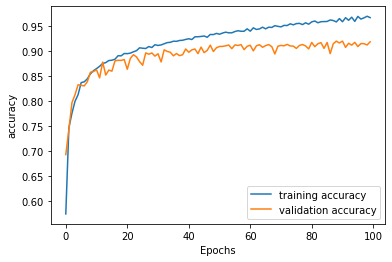

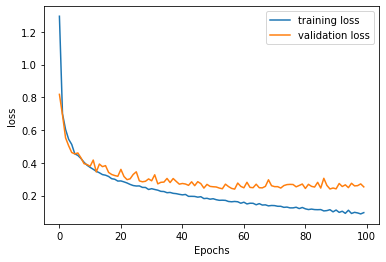

In [148]:
def plot_training(model_history, measure):
    plt.plot(history.history[measure])
    plt.plot(history.history['val_'+measure])
    plt.xlabel('Epochs')
    plt.ylabel(measure)
    plt.legend(['training '+ measure,'validation '+ measure])
    plt.show()

plot_training(history, 'accuracy')
plot_training(history, 'loss')

In [154]:
#tuning

tuner_batch32 = kt.Hyperband(fmnist_tuner,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='models',
                     project_name='fmnist_with_cnn_batch32')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5)

In [ ]:
tuner_batch32.search(training_images, training_labels, epochs = 50, validation_split = 0.2)

In [56]:
best_batch32 = tuner_batch32.get_best_hyperparameters(num_trials=10)[0]

print(f'Dense units: {best_batch_32.get('dense_units')})
print(f'Learning rate: {best_batch32.get('learning_rate')})
print(f'Conv filters: {best_batch32.get('conv_units')})

In [154]:
batch_sizes=[8,16,32,64,128,256,512,1024]
optimal_hyperparameters = []

for size in batch_sizes:
    tuner= kt.Hyperband(fmnist_tuner,
                         objective='val_accuracy',
                         max_epochs=20,
                         factor=3,
                         directory='models',
                         project_name=f'fmnist_with_cnn_batch{size}')
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5)
    
    tuner.search(training_images, training_labels, epochs = 50, validation_split = 0.2, batch_size=size)
    best_params = tuner.get_best_hyperparameters(num_trials=20)[0]
    
    optimal_hyperparameters.append(f'batch_size = {size}',
                                   f'Dense units: {best_params.get('dense_units')}',
                                   f'Learning rate: {best_params.get('learning_rate')}',
                                   f'Conv filters: {best_params.get('conv_units')}'
                                   )